# Part 0: Imports and helper functions

In [57]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import glob
import subprocess
import math
import random
import time
from joblib import dump, load
import matplotlib.colors as mcolors

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles, GetScaffoldForMol
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Cluster import Butina

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')

from e3fp.pipeline import fprints_from_mol, fprints_from_smiles
from e3fp.config.params import default_params
from e3fp.pipeline import params_to_dicts

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

In [65]:
# helper functions
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

def multiple_labels(df, col_name):
    '''
    splits drugs with multiple mechanisms of action
    '''
    df[col_name] = df[col_name].str.split(', ')
    df = df.explode(col_name, ignore_index=True)
    return df

# generate Xs and Ys from chemprop embeddings
def read_chemprop_embeddings(embeddings_filepath,labels_filepath):
    '''
    embeddings_filepath: file path to chemprop embeddings
    labels_filepath: file path to labels
    returns
    Xs: list of input np.arrays
    Ys: list of OHE np.arrays of labels
    '''
    X = pd.read_csv(embeddings_filepath)
    Y = pd.read_csv(labels_filepath)
    Xwidth = X.shape[1]
    Ywidth = Y.shape[1]
    Xs = []
    Ys = []
    for idx in range(len(X)):
        Xs.append(np.array(X.iloc[idx,1:Xwidth].to_list()))
        Ys.append(np.array(Y.iloc[idx,1:Ywidth].to_list()))
    return Xs, Ys

def plot_roc_prc_curves(clf, type_of_class, X_test, y_test, n_classes, type_of_input, figsize=(8, 6)):
    '''
    clf: sklearn classifier object
    type_of_class: str name of classifier; only allow 'rfc', 'gpc', 'knn', 'svm'
    X_test: test set inputs
    y_test: test set labels
    n_classes: int number of classes or labels in the data set
    type_of_input: str name of input type; e.g. 'morgan', 'embedding', 'broad_embedding'
    
    returns: list of two dictionaries containing auROC and auPR for each class and the microaverage
    '''
    
    if type_of_class == 'rfc' or type_of_class == 'gpc' or type_of_class == 'knn':
        y_score = clf.predict_proba(X_test) # this makes gpc work even though it's predicting numeric class
    elif type_of_class == 'svm':
        y_score = clf.decision_function(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    prc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        prc_auc[i] = average_precision_score(y_test[:, i], y_score[:, i])
    roc_auc[n_classes+1] = roc_auc_score(y_test, y_score, multi_class='ovr', average='micro')
    prc_auc[n_classes+1] = average_precision_score(y_test, y_score, average="micro")
    
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('font',size=24)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s (area = %0.4f)' % (ordered_labels[i],roc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged AUROC: %0.4f' % roc_auc[n_classes+1])
    leg = ax.legend(loc="lower center",fontsize=18)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


    ax.grid(alpha=.4)
    sns.despine()
    # change save file name as needed
    fig.savefig('../outputs/'+type_of_class+'_ROC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    
    # prc for each class
    fig, ax = plt.subplots(figsize=figsize)
    plt.rc('font',size=24)
#     ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
#     ax.set_title('Precision Recall curve')
    for i in range(n_classes):
        ax.plot(recall[i], precision[i], label='%s (area = %0.4f)' % (ordered_labels[i], prc_auc[i]), linewidth=4)
    ax.plot([], [], ' ', label='Micro-averaged precision: %0.4f' % prc_auc[n_classes+1])
    leg = ax.legend(loc="lower center",fontsize=20)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    xOffset = -1.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

    ax.grid(alpha=.4)
    sns.despine()
    fig.savefig('../outputs/'+type_of_class+'_PRC_multiclass_nonhuman_'+type_of_input+'.png', bbox_inches='tight')
    plt.show()
    
    return [roc_auc, prc_auc]

def auroc_aupr_barchart(plot_type, y1s, y2s, class_list, clf_list, width=0.05):
    '''
    generates barchart with all auPR and auROC for each label and for each classifier
    '''
    colors = list(mcolors.TABLEAU_COLORS)[:len(class_list)]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2*len(class_list))]
    fig, ax = plt.subplots(figsize=(10,6))
    
    odd = False
    for class_idx, x in enumerate(xs):
#         if class_idx >= len(class_list):
#             class_idx -= len(class_list)
        if odd:
            class_idx = int((class_idx+1)/2-1)
            heights = [ylist[0][class_idx] for ylist in y1s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auROC',align='edge',color=colors[class_idx],edgecolor='black',alpha=0.6,hatch='//')
        else:
            class_idx = int(class_idx/2)
            heights = [ylist[0][class_idx] for ylist in y2s]
            plt.bar(x=x,height=heights,width=width,label=class_list[class_idx]+' auPR',align='edge',color=colors[class_idx],edgecolor='black')
        odd = not odd
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(class_list) for r in range(len(clf_list))], clf_list)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/multiclass_predict_human_aupr_auroc.png',bbox_inches='tight')
    
def ord_to_OHE(ord_preds, n_classes):
    '''
    converts ordinal labels (0, 1, 2...) to one hot encodings ([1,0,0...])
    '''
    OHE_preds = []
    for y in ord_preds:
        OHE_pred = np.zeros(np.max(n_classes))
        OHE_pred[y] = 1
        OHE_preds.append(OHE_pred.astype(int))
    return np.vstack(OHE_preds)    

def auroc_aupr_dot_barchart(plot_type, y1s, y2s, class_list, clf_names, clf_list, width=0.05):
    '''
    generate barcharts of micro-averaged auROC and auPR of each classifier; dots represent each label
    '''
    colors = list(mcolors.TABLEAU_COLORS)[:2]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(2)]
    fig, ax = plt.subplots(figsize=(10,6))
    n_classes = len(class_list)
    
    ys = [y1s, y2s]
    for idx, x in enumerate(xs):
        heights = [y[n_classes+1] for y in ys[idx]]
        plt.bar(x=x,height=heights,width=width,label=['auROC','auPR'][idx],align='edge',color=colors[idx],edgecolor='black',alpha=0.6,hatch='')    
        for class_idx in range(n_classes):    
            plt.plot([xi+width*len(clf_list)/8 for xi in x],[ys[idx][clf_idx][class_idx] for clf_idx in range(len(clf_names))],marker='.',linestyle='',color='black')
    plt.rc('font', size=20) 
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(clf_list)/4 for r in range(len(clf_list))], clf_names)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/multiclass_predict_human_aupr_auroc_slides.png',bbox_inches='tight')
    
def multiclass_metrics_barchart(plot_type, y1s, y2s, y3s, clf_names, clf_list, width=0.05):
    '''
    generates barchart of accuracy, Cohen Kappa score and Matthews correlation coefficient
    '''
    colors = list(mcolors.TABLEAU_COLORS)[:3]
    # xs: list of offset x values for each class
    xs = [np.arange(len(clf_list))+width*i for i in range(3)]
    fig, ax = plt.subplots(figsize=(10,6))
    
    ys = [y1s, y2s, y3s]
    for idx, y in enumerate(ys):
        heights = [y[type_of_class] for type_of_class in clf_names]
        plt.bar(x=xs[idx],height=heights,width=width,label=['Test Accuracy','Cohen Kappa Score','Matthews Correlation'][idx],align='edge',color=colors[idx],edgecolor='black',alpha=0.6,hatch='')
    plt.xlabel('Classifier')
    plt.ylabel(plot_type)
    plt.xticks([r+width*len(clf_list)/4*1.5 for r in range(len(clf_list))], clf_names)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.rc('font', size=20) 
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    fig.savefig('../outputs/multiclass_predict_human_metrics_slides.png',bbox_inches='tight')

# Part 1: Read in data and creating inputs

In [33]:
# get morgan fingerprints for all
data_dir = '../data/'
file_name = 'abx_MOA_fully_relabeled_v2.csv'
file_path = data_dir+file_name

drugs = pd.read_csv(file_path)
print('initial length:',len(drugs))
not_nans = [type(smi) != float for smi in list(drugs['canon_SMILES'])]
drugs = drugs[not_nans] # filter for having SMILE
print('filtered for SMILES:',len(drugs))

# single label multiclass
labeled_drugs = multiple_labels(labeled_drugs,'labels') # dealing with multiple MOA
labeled_drugs.replace('DNA','nucleic acid', inplace=True)
labeled_drugs.replace('protein','protein biosynthesis', inplace=True)

    
# labeled abx
labeled_mols = [Chem.MolFromSmiles(x) for x in labeled_drugs['canon_SMILES']]
labeled_drugs['mols'] = labeled_mols
labeled_fps = [Chem.RDKFingerprint(x) for x in labeled_mols if x is not None]

# holding out Brochado compounds
training_mask = [label != 'brochados' for label in labeled_drugs['hold_out']]
training_df = labeled_drugs[training_mask]
# filtering out human drugs
class_mask = [label in ['nucleic acid','cell division','cell wall','CoA synthesis','protein biosynthesis','membrane','oxidative stress', 'PMF'] for label in training_df['labels']]
training_df = training_df[class_mask]
training_df['smiles'] = training_df['canon_SMILES']
training_df.to_csv('../data/chemprop_feat_smiles_predict_human.csv')

training_mols = [Chem.MolFromSmiles(x) for x in training_df['canon_SMILES']]
training_fps = [Chem.RDKFingerprint(x) for x in training_mols if x is not None]

initial length: 2857
filtered for SMILES: 2856


In [34]:
# training set for single label multiclass
one = OneHotEncoder()
df = training_df['labels'].to_frame()
OHE_df = one.fit_transform(df)
OHE_labels = OHE_df.to_numpy()
training_df['OHE_labels'] = [OHE_label for OHE_label in OHE_labels]
training_df.head(10)
ordered_labels = [label[8:-1] for label in OHE_df.columns.values]
# one.inverse_transform() works because it inherits from sklearn OneHotEncoder!

In [35]:
# embeddings from model trained on training set
chemprop_Xs, chemprop_Ys = read_chemprop_embeddings(embeddings_filepath = '../data/' + 'chemprop_nonhuman_multilabel_inputs' + '/fingerprints.csv', labels_filepath = '../data/' + 'chemprop_nonhuman_multilabel_inputs' + '/all.csv')

In [36]:
# embeddings from model trained on Stokes et al. 2020 Broad dataset
embeddings_filepath = '../data/' + 'chemprop_nonhuman_multilabel_inputs/' + 'broad_encoded_fingerprints_fold_0.csv'
labels_filepath = '../data/' + 'chemprop_nonhuman_multilabel_inputs/' + 'all.csv'
broad_chemprop_Xs, broad_chemprop_Ys = read_chemprop_embeddings(embeddings_filepath, labels_filepath)

In [37]:
### Must run "sh generate_features_v1.sh" in terminal first to generate .npz file ###

# get rdkit props for all
# below are chemprop features; need to re-generate chemprop features
props = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v','EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2','EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6','EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt','FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3','FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt','Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex','MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge','MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex','MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount',  'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms','NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles','NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons','PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5','PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount','SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5','SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4','SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9','TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3','VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8','VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN','fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2','fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0','fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide','fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine','fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester','fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone','fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine','fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho','fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol','fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine','fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
a = np.load('../data/smiles_fts_multiclass_predict_human.npz') # check .sh file
d = dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))
allprops = pd.DataFrame(d['data1features'], columns = props)
# names = pd.read_csv('../data/clean_screen_for_ml.csv')
allprops['SMILES'] = training_df['canon_SMILES']
allprops['labels'] = training_df['OHE_labels']
allprops = allprops.drop_duplicates(subset = 'SMILES')
is_not_NaN = allprops.notnull()
row_no_NaN = is_not_NaN.all(axis=1)

allprops = allprops[row_no_NaN]
justprops = allprops[props].values

props_y = allprops['labels']

smiles = list(allprops['SMILES'])
mols = [Chem.MolFromSmiles(x) for x in smiles]
fps = [Chem.RDKFingerprint(x) for x in mols if x is not None]
fps_y = list(allprops['labels'])

# Part 2: Simple classifiers

In [38]:
def class_balanced_split(X, Y, train_split=0.8, val_split=None, numsplits=5):
    '''
    returns class balanced split of data with specified split ratios and number of splits
    random seed of 0.42 set for reproducibility of split
    '''
    def divide(lst, n):
        p = len(lst) // n
        if len(lst)-p > 0:
            return [lst[:p]] + divide(lst[p:], n-1)
        else:
            return [lst]
    def seed():
        return 0.42

    n_classes = list(Y)[0].shape[0]
    Xtrains = []
    Ytrains = []
    Xtest = []
    Ytest = []
    Xval = []
    Yval = []
    balanced_dict = {}
    
    # making train/test/val splits within classes
    for i in range(n_classes):
        xlist = []
        ylist = []
        for x, y in zip(X,Y):
            if np.argmax(y) == i:
                xlist.append(x)
                ylist.append(y)
        X_train, X_test, y_train, y_test = train_test_split(xlist, ylist, train_size=train_split, random_state=0)
        if val_split:
            val_train_size = round(1-val_split/(1-train_split), 3)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=val_train_size, random_state=0)
            balanced_dict[i] = (X_train, y_train, X_test, y_test, X_val, y_val)
        else:
            balanced_dict[i] = (X_train, y_train, X_test, y_test)
    # recombining train/test/val
    for i in range(n_classes):
        Xtrains.extend(balanced_dict[i][0])
        Ytrains.extend(balanced_dict[i][1])
        Xtest.extend(balanced_dict[i][2])
        Ytest.extend(balanced_dict[i][3])
        if val_split:
            Xval.extend(balanced_dict[i][4])
            Yval.extend(balanced_dict[i][5])
    

    # shuffling recombined train/test/val
    train = list(zip(Xtrains,Ytrains))
    test = list(zip(Xtest,Ytest))
    random.shuffle(train, seed)
    random.shuffle(test, seed)   
    # splitting into numsplits and shuffling 
    split_train = divide(train, numsplits)
    split_test = divide(test, numsplits)
    for split in split_train:
        random.shuffle(split, seed)
    for split in split_test:
        random.shuffle(split, seed)
    if val_split:
        val = list(zip(Xval,Yval))
        random.shuffle(val, seed)
        split_val = divide(val, numsplits)
        for split in split_val:
            random.shuffle(split, seed)

    # unzipping and making list of lists
    Xtrains = []
    Ytrains = []
    Xtests = []
    Ytests = []
    for i in range(numsplits):
        # you can use zip(*iterable) to unzip split_train[i]
        Xtrains.append([train[0] for train in split_train[i]])
        Ytrains.append([train[1] for train in split_train[i]])
        Xtests.append([test[0] for test in split_test[i]])
        # Xtests.append(np.array([test[0] for test in split_test[i]]))
        Ytests.append([test[1] for test in split_test[i]])
    if val_split:
        Xvals = []
        Yvals = []
        for i in range(numsplits):
            Xvals.append([val[0] for val in split_val[i]])
            Yvals.append([val[1] for val in split_val[i]])
        return Xtrains, Ytrains, Xtests, Ytests, Xvals, Yvals
    return Xtrains, Ytrains, Xtests, Ytests

In [39]:
# define classifier function
def classifier(type_of_class, numsplits, xs, ys, type_of_input):
    '''
    call to run sklearn classifier
    type_of_class: str name of classifier; 'gpc', 'rfc', 'knn', 'svm'
    numsplits: int number of splits of data
    xs: all inputs
    ys: all labels
    type_of_input: str name of input type; e.g. 'embedding' or 'morgan'
    '''
    Xtrains, ytrains, Xtests, ytests = class_balanced_split(xs, ys, numsplits=numsplits)
    test_acc = []
    AUROC = []
    average_precision = []
    
    ypreds = []
    ytrue = []
    for i in range(numsplits):
        if type_of_class == 'rfc':
            clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 500, max_depth=5, random_state=0))
            clf = clf.fit(Xtrains[i], ytrains[i])
            ypred = clf.predict(Xtests[i])
            ypred_numeric = np.array([np.argmax(pred) for pred in ypred])
            ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
            ypreds.extend(ypred_numeric)
            ytrue.extend(ytest_numeric)
            acc = clf.score(Xtests[i], np.vstack(ytests[i]))
            print('Accuracy for model ' + str(i) + ': ' + str(acc))
            test_acc.append(acc)
            rocprc = plot_roc_prc_curves(clf, type_of_class, Xtests[i], np.vstack(ytests[i]), len(ytests[0][0]), type_of_input)
            AUROC.append(rocprc[0])
            average_precision.append(rocprc[1])
            
        elif type_of_class == 'svm':
            ytrains[i] = np.array([np.argmax(ytrain) for ytrain in ytrains[i]])
            clf = OneVsRestClassifier(SVC(gamma='auto'))
            clf = clf.fit(Xtrains[i], ytrains[i])
            ypred = clf.predict(Xtests[i])
            ypred_numeric = ypred
            ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
            ypreds.extend(ypred_numeric)
            ytrue.extend(ytest_numeric)
            acc = clf.score(Xtests[i], ytest_numeric)
            print('Accuracy for model ' + str(i+1) + ': ' + str(acc))
            test_acc.append(acc)
            rocprc = plot_roc_prc_curves(clf, type_of_class, Xtests[i], np.vstack(ytests[i]), len(ytests[0][0]),type_of_input)
            AUROC.append(rocprc[0])
            average_precision.append(rocprc[1])
            
        elif type_of_class == 'gpc':
            ytrains[i] = np.array([np.argmax(ytrain) for ytrain in ytrains[i]])
            kernel = 1.0 * RBF(1.0)
            clf = GaussianProcessClassifier(kernel=kernel, random_state=0, multi_class='one_vs_rest')
            clf = clf.fit(Xtrains[i], ytrains[i])
            ypred = clf.predict(Xtests[i])
            ypred_numeric = ypred
            ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
            ypreds.extend(ypred_numeric)
            ytrue.extend(ytest_numeric)
            acc = clf.score(Xtests[i], ytest_numeric)
            print('Accuracy for model ' + str(i) + ': ' + str(acc))
            test_acc.append(acc)
            rocprc = plot_roc_prc_curves(clf, type_of_class, Xtests[i], np.vstack(ytests[i]), len(ytests[0][0]),type_of_input)
            AUROC.append(rocprc[0])
            average_precision.append(rocprc[1])
            yprobs = clf.predict_proba(Xtests[i])
#             print('Sample prediction:', yprobs[:10])
        elif type_of_class == 'knn':
            ytrains[i] = np.array([np.argmax(ytrain) for ytrain in ytrains[i]])
            clf = KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm='ball_tree')
            clf = clf.fit(Xtrains[i], ytrains[i])
            ypred = clf.predict(Xtests[i])
            ypred_numeric = ypred #np.array([np.argmax(pred) for pred in ypred])
            ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
            ypreds.extend(ypred_numeric)
            ytrue.extend(ytest_numeric)
            acc = clf.score(Xtests[i], ytest_numeric)
            test_acc.append(acc)
            print('Accuracy for model ' + str(i) + ': ' + str(acc))
            rocprc = plot_roc_prc_curves(clf, type_of_class, Xtests[i], np.vstack(ytests[i]), len(ytests[0][0]),type_of_input)
            AUROC.append(rocprc[0])
            average_precision.append(rocprc[1])

            
    cks = cohen_kappa_score(ypreds, ytrue)        
    mcc = matthews_corrcoef(ypreds, ytrue)
    print('Cohen kappa score: ' + str(cks))
    print('Matthews correlation coefficient: ' + str(mcc))
    
    return clf, test_acc, AUROC, average_precision, mcc, cks

In [ ]:
# runs rfc, svm, gpc, knn sklearn models on embeddings from chemprop trained on the Broad dataset
type_of_input = 'broad_embedding'
filler = '**************************'

numsplits = 1
model = 'rfc'
print(filler)
print('trying ' + model + ' on broad embedding fps with ' + str(numsplits) + ' non-overlapping splits')
rfc, rfc_test_acc, rfc_AUROC, rfc_AUPR, rfc_mcc, rfc_cks = classifier(model, numsplits, broad_chemprop_Xs, broad_chemprop_Ys, type_of_input=type_of_input)
dump(rfc, '../outputs/rfc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'svm'
print(filler)
print('trying ' + model + ' on broad embedding fps with ' + str(numsplits) + ' non-overlapping splits')
svm, svm_test_acc, svm_AUROC, svm_AUPR, svm_mcc, svm_cks = classifier(model, numsplits, broad_chemprop_Xs, broad_chemprop_Ys, type_of_input=type_of_input)
dump(svm, '../outputs/svm_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'gpc'
print(filler)
print('trying ' + model + ' on broad embedding fps with ' + str(numsplits) + ' non-overlapping splits')
gpc, gpc_test_acc, gpc_AUROC, gpc_AUPR, gpc_mcc, gpc_cks = classifier(model, numsplits, broad_chemprop_Xs, broad_chemprop_Ys, type_of_input=type_of_input)
dump(gpc, '../outputs/gpc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'knn'
print(filler)
print('trying ' + model + ' on broad embedding fps with ' + str(numsplits) + ' non-overlapping splits')
knn, knn_test_acc, knn_AUROC, knn_AUPR, knn_mcc, knn_cks = classifier(model, numsplits, broad_chemprop_Xs, broad_chemprop_Ys, type_of_input=type_of_input)
dump(knn, '../outputs/knn_predict_human_'+type_of_input+'.joblib')



**************************
trying rfc on morgan fps with 1 non-overlapping splits
Accuracy for model 0: 0.867704280155642


<ipython-input-58-f5592604126c>:39: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-58-f5592604126c>:65: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


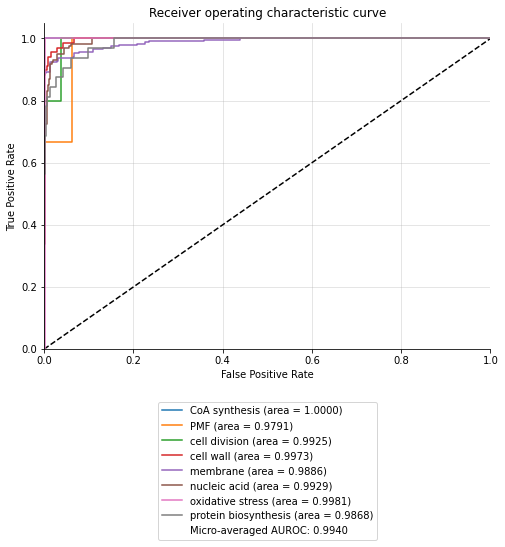

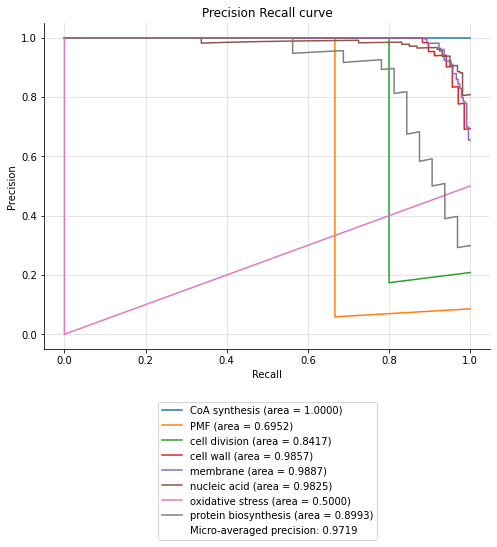

Cohen kappa score: 0.8080304136727743
Matthews correlation coefficient: 0.8138738995424268
**************************
trying svm on morgan fps with 1 non-overlapping splits
Accuracy for model 1: 0.9357976653696498


<ipython-input-58-f5592604126c>:39: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-58-f5592604126c>:65: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


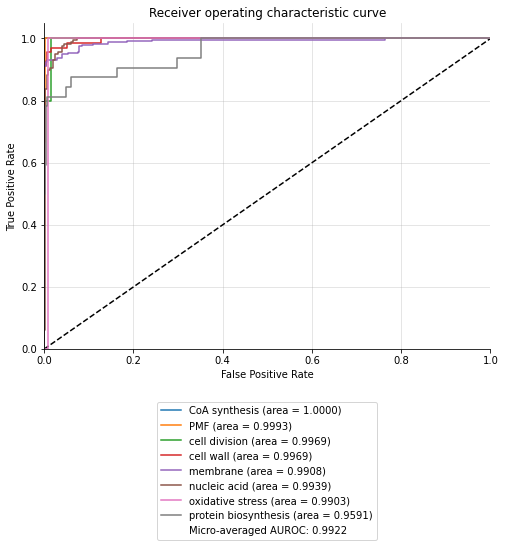

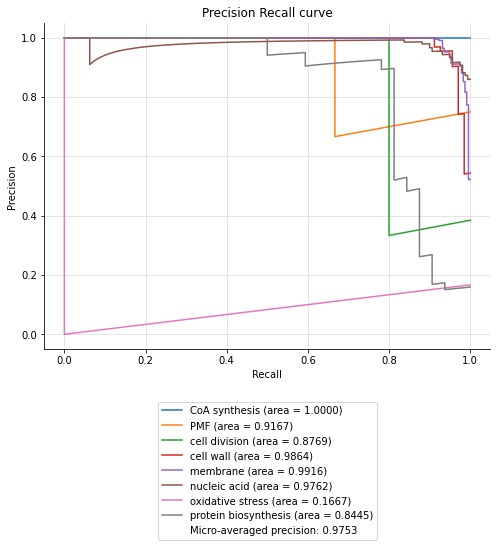

Cohen kappa score: 0.9036156901518897
Matthews correlation coefficient: 0.9039682806881698
**************************
trying gpc on morgan fps with 1 non-overlapping splits
Accuracy for model 0: 0.9377431906614786


<ipython-input-58-f5592604126c>:39: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-58-f5592604126c>:65: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


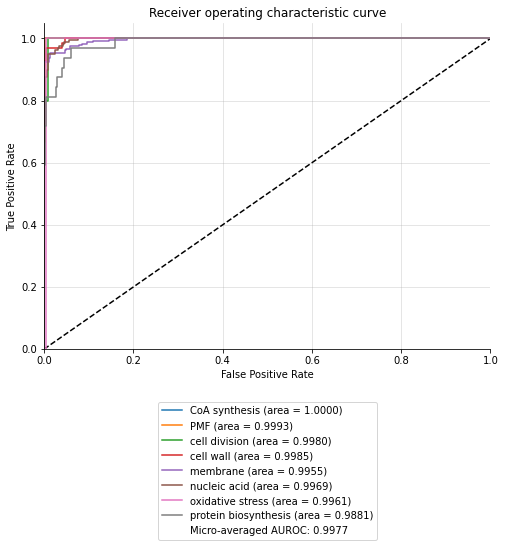

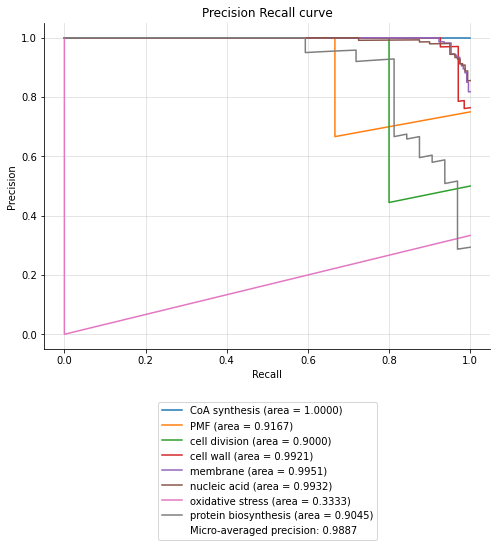

Cohen kappa score: 0.9067076560071694
Matthews correlation coefficient: 0.9069643401584367
**************************
trying knn on morgan fps with 1 non-overlapping splits
Accuracy for model 0: 0.9494163424124513


<ipython-input-58-f5592604126c>:39: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-58-f5592604126c>:65: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


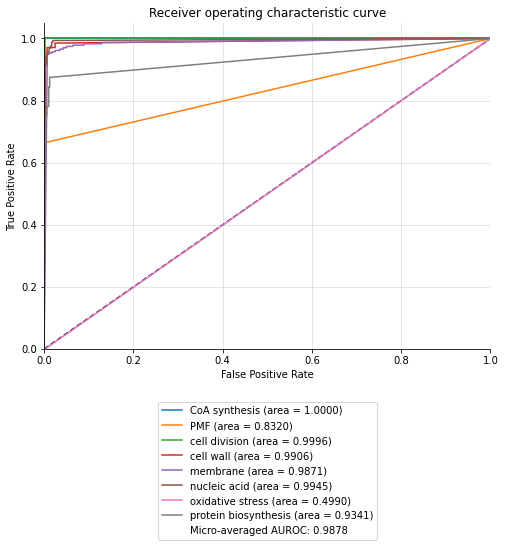

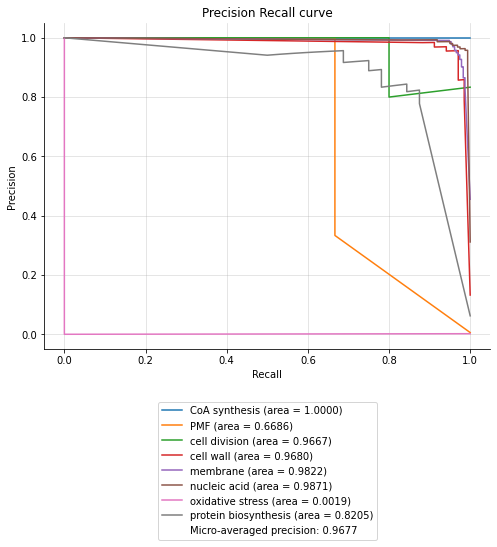

Cohen kappa score: 0.9245657904392051
Matthews correlation coefficient: 0.924697720494775


['../outputs/knn_morgan_predict_human.joblib']

In [61]:
# Runs classifiers on ECFP4 RDKFingerprints
filler = '**************************'
type_of_input = 'morgan'

numsplits = 1
model = 'rfc'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
rfc, rfc_test_acc, rfc_AUROC, rfc_AUPR, rfc_mcc, rfc_cks = classifier(model, numsplits, fps, fps_y, 'morgan')
dump(rfc, '../outputs/rfc_morgan_predict_human.joblib')

numsplits = 1
model = 'svm'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
svm, svm_test_acc, svm_AUROC, svm_AUPR, svm_mcc, svm_cks = classifier(model, numsplits, fps, fps_y, 'morgan')
dump(svm, '../outputs/svm_morgan_predict_human.joblib')

numsplits = 1
model = 'gpc'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
gpc, gpc_test_acc, gpc_AUROC, gpc_AUPR, gpc_mcc, gpc_cks = classifier(model, numsplits, fps, fps_y, 'morgan')
dump(gpc, '../outputs/gpc_morgan_predict_human.joblib')

numsplits = 1
model = 'knn'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
knn, knn_test_acc, knn_AUROC, knn_AUPR, knn_mcc, knn_cks = classifier(model, numsplits, fps, fps_y, 'morgan')
dump(knn, '../outputs/knn_morgan_predict_human.joblib')

**************************
trying rfc on embedding fps with 1 non-overlapping splits
Accuracy for model 0: 0.8853046594982079


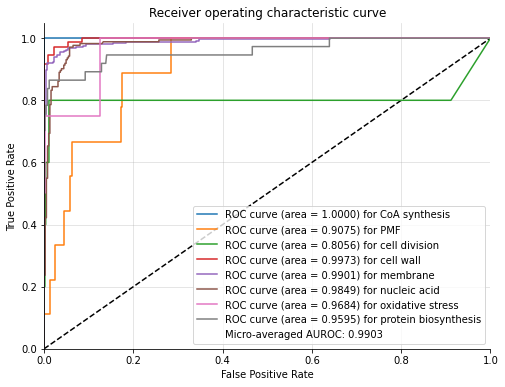

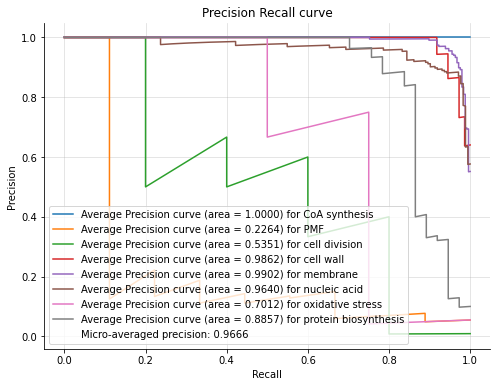

Cohen kappa score: 0.8396700342941885
Matthews correlation coefficient: 0.842807735371719
**************************
trying svm on embedding fps with 1 non-overlapping splits embedding
Accuracy for model 1: 0.9050179211469535


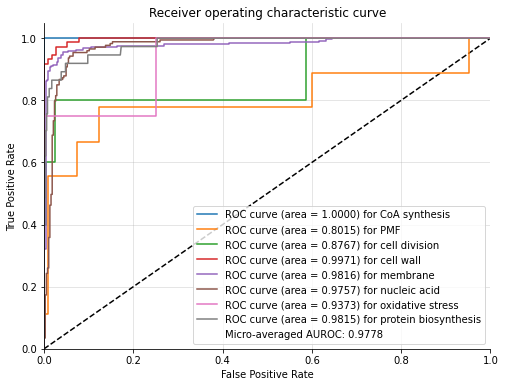

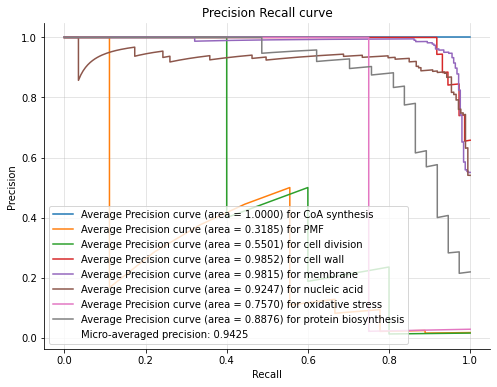

Cohen kappa score: 0.8585152086343326
Matthews correlation coefficient: 0.8598946701122075
**************************
trying knn on embedding fps with 1 non-overlapping splits embedding
Accuracy for model 0: 0.9372759856630825


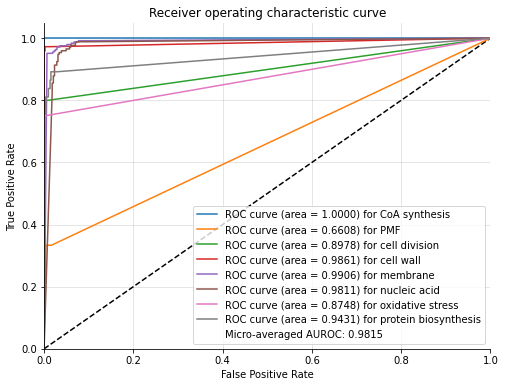

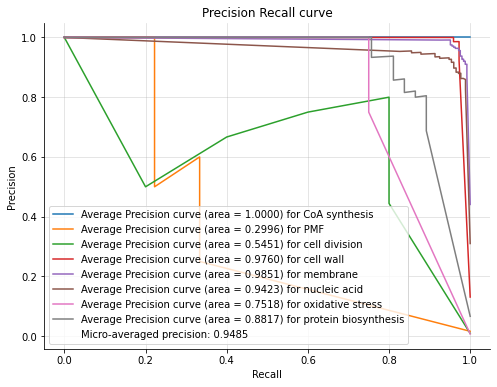

Cohen kappa score: 0.9076731070150474
Matthews correlation coefficient: 0.9080379016098817


['../outputs/knn_predict_human_embedding.joblib']

In [ ]:
# runs models on chemprop embeddings with model trained on MOA dataset
type_of_input = 'embedding'
filler = '**************************'

numsplits = 1
model = 'rfc'
print(filler)
print('trying ' + model + ' on embedding fps with ' + str(numsplits) + ' non-overlapping splits')
rfc, rfc_test_acc, rfc_AUROC, rfc_AUPR, rfc_mcc, rfc_cks = classifier(model, numsplits, chemprop_Xs, chemprop_Ys, type_of_input=type_of_input)
dump(rfc, '../outputs/rfc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'svm'
print(filler)
print('trying ' + model + ' on embedding fps with ' + str(numsplits) + ' non-overlapping splits','embedding')
svm, svm_test_acc, svm_AUROC, svm_AUPR, svm_mcc, svm_cks = classifier(model, numsplits, chemprop_Xs, chemprop_Ys, type_of_input=type_of_input)
dump(svm, '../outputs/svm_predict_human_'+type_of_input+'.joblib')


numsplits = 1
model = 'gpc'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
gpc, gpc_test_acc, gpc_AUROC, gpc_AUPR, gpc_mcc, gpc_cks = classifier(model, numsplits, chemprop_Xs, chemprop_Ys, type_of_input=type_of_input)
dump(gpc, '../outputs/gpc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'knn'
print(filler)
print('trying ' + model + ' on embedding fps with ' + str(numsplits) + ' non-overlapping splits','embedding')
knn, knn_test_acc, knn_AUROC, knn_AUPR, knn_mcc, knn_cks = classifier(model, numsplits, chemprop_Xs, chemprop_Ys, type_of_input=type_of_input)
dump(knn, '../outputs/knn_predict_human_'+type_of_input+'.joblib')



In [43]:
auroc_list = [rfc_AUROC, svm_AUROC, gpc_AUROC, knn_AUROC]
aupr_list = [rfc_AUPR, svm_AUPR, gpc_AUPR, knn_AUPR]
clf_list = ['rfc','svm','gpc','knn']
class_list = ordered_labels

NameError: name 'rfc_AUROC' is not defined

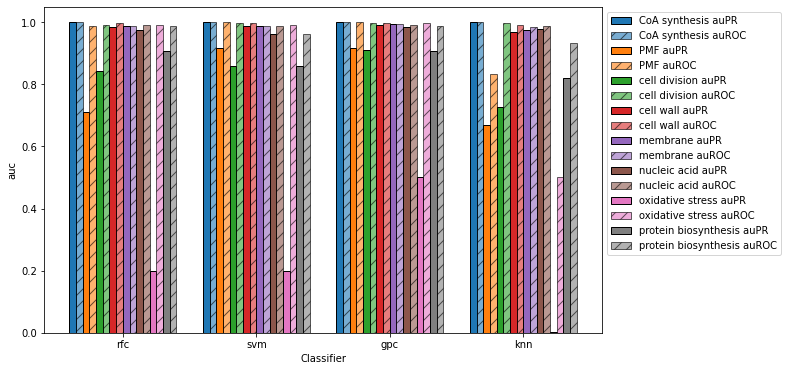

In [21]:
auroc_aupr_barchart('auc',auroc_list,aupr_list,class_list,clf_list)

# Part 3: Predicting on human drugs

In [44]:
# loading classifiers
gpc = load('../outputs/gpc_morgan_predict_human.joblib')
rfc = load('../outputs/rfc_morgan_predict_human.joblib')
svm = load('../outputs/svm_morgan_predict_human.joblib')
knn = load('../outputs/knn_morgan_predict_human.joblib')

In [45]:
# subsetting to human compounds not in Brochados set

training_mask = [label != 'brochados' for label in labeled_drugs['hold_out']]
human_df = labeled_drugs[training_mask]
class_mask = [label == 'human' for label in human_df['labels']]
human_df = human_df[class_mask]
human_df['smiles'] = human_df['canon_SMILES']
human_df.to_csv('../outputs/chemprop_feat_smiles_human.csv')

human_df

,Unnamed: 0,Compound,SMILES,canon_SMILES,Broad MOA,Specific Target,Class,Link to study,"Gram +/-, mycobacteria","Species (E coli, E coli K12:OHxxx)","Strain info if available (resistant, clinical, WT)",Comments,hold_out,labels,mols,smiles
167,165,ISOLIQUIRITIGENIN,C1=CC(=CC=C1C=CC(=O)C2=C(C=C(C=C2)O)O)O,O=C(C=Cc1ccc(O)cc1)c1ccc(O)cc1O,human,NaN,NaN,https://www-nature-com.ezp-prod1.hul.harvard.e...,negative,P. aeruginosa,NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb67d9fa0>,O=C(C=Cc1ccc(O)cc1)c1ccc(O)cc1O
171,169,MERCAPTOPURINE,C1=NC2=C(N1)C(=S)N=CN2,S=c1nc[nH]c2nc[nH]c12,human,NaN,chemotherapeutic,https://www-nature-com.ezp-prod1.hul.harvard.e...,negative,P. aeruginosa,NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb67d9340>,S=c1nc[nH]c2nc[nH]c12
172,171,THIAMIPRINE,CN1C=NC(=C1SC2=NC(=NC3=C2NC=N3)N)[N+](=O)[O-],Cn1cnc([N+](=O)[O-])c1Sc1nc(N)nc2nc[nH]c12,human,NaN,NaN,https://www-nature-com.ezp-prod1.hul.harvard.e...,negative,P. aeruginosa,NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb67d9dc0>,Cn1cnc([N+](=O)[O-])c1Sc1nc(N)nc2nc[nH]c12
174,173,carmofur,CCCCCCNC(=O)N1C=C(C(=O)NC1=O)F,CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O,human,NaN,chemotherapeutic,https://www-nature-com.ezp-prod1.hul.harvard.e...,negative,P. aeruginosa,NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb67d9d00>,CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O
175,174,trimetrexate glucuronate,CC1=C(C=CC2=C1C(=NC(=N2)N)N)CNC3=CC(=C(C(=C3)O...,COc1cc(NCc2ccc3nc(N)nc(N)c3c2C)cc(OC)c1OC.O=CC...,human,NaN,chemotherapeutic,https://www-nature-com.ezp-prod1.hul.harvard.e...,negative,P. aeruginosa,NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb67d9e80>,COc1cc(NCc2ccc3nc(N)nc(N)c3c2C)cc(OC)c1OC.O=CC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,355,candesartan cilexetil,CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4...,CCOc1nc2cccc(C(=O)OC(C)OC(=O)OC3CCCCC3)c2n1Cc1...,human,NaN,NaN,http://europepmc.org/backend/ptpmcrender.fcgi?...,positive,"MRSA, VRSA",NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb6260dc0>,CCOc1nc2cccc(C(=O)OC(C)OC(=O)OC3CCCCC3)c2n1Cc1...
348,356,solifenacin succinate,C1CN2CCC1C(C2)OC(=O)N3CCC4=CC=CC=C4C3C5=CC=CC=...,O=C(O)CCC(=O)O.O=C(OC1CN2CCC1CC2)N1CCc2ccccc2C...,human,NaN,NaN,http://europepmc.org/backend/ptpmcrender.fcgi?...,positive,"MRSA, VRSA",NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb6260d60>,O=C(O)CCC(=O)O.O=C(OC1CN2CCC1CC2)N1CCc2ccccc2C...
349,357,benzbromarone,CCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)Br)O)Br,CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1,human,NaN,NaN,http://europepmc.org/backend/ptpmcrender.fcgi?...,positive,"MRSA, VRSA",NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb6260d00>,CCc1oc2ccccc2c1C(=O)c1cc(Br)c(O)c(Br)c1
350,359,oxymetazoline hydrochloride,CC1=CC(=C(C(=C1CC2=NCCN2)C)O)C(C)(C)C.Cl,Cc1cc(C(C)(C)C)c(O)c(C)c1CC1=NCCN1.Cl,human,NaN,NaN,http://europepmc.org/backend/ptpmcrender.fcgi?...,positive,"MRSA, VRSA",NaN,NaN,NaN,human,<rdkit.Chem.rdchem.Mol object at 0x7efeb6260ca0>,Cc1cc(C(C)(C)C)c(O)c(C)c1CC1=NCCN1.Cl


In [46]:
# get rdkit props for all
# below are chemprop features; need to re-generate chemprop features
props = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v','EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2','EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6','EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt','FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3','FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt','Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex','MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge','MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex','MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount',  'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms','NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles','NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons','PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5','PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount','SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5','SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4','SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9','TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3','VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8','VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN','fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2','fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0','fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide','fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine','fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester','fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone','fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine','fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho','fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol','fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine','fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
a = np.load('../data/smiles_fts_multiclass_human.npz') # check .sh file
# a = np.load('../data/smiles_fts_multiclass_predict_human.npz') # check .sh file

d = dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))
allprops = pd.DataFrame(d['data1features'], columns = props)
allprops['SMILES'] = human_df['canon_SMILES'].to_list()
allprops['compound'] = human_df['Compound'].to_list()

allprops = allprops.drop_duplicates(subset = 'SMILES')
# allprops

In [47]:
is_not_NaN = allprops.notnull()
row_no_NaN = is_not_NaN.all(axis=1)

allprops = allprops[row_no_NaN]
justprops = allprops[props].values

# print(justprops)
# props_y = allprops['labels']

smiles = list(allprops['SMILES'])
names = allprops['compound'].to_list()
test_mols = [Chem.MolFromSmiles(x) for x in allprops['SMILES']]
test_fps = [Chem.RDKFingerprint(x) for x in test_mols if x is not None]
# fps_y = list(allprops['labels'])

In [48]:
# morgan fp inputs
x_human = test_fps

In [50]:
# using models to predict on human drug inputs
n_classes = len(set(training_df['labels']))
rfc_ord_preds = np.argmax(rfc.predict_proba(x_human), axis=1)
rfc_preds = ord_to_OHE(rfc_ord_preds,n_classes)
svm_ord_preds = svm.predict(x_human)
svm_preds = ord_to_OHE(svm_ord_preds,n_classes)
gpc_ord_preds = gpc.predict(x_human)
gpc_preds = ord_to_OHE(gpc_ord_preds,n_classes)
knn_ord_preds = knn.predict(x_human)
knn_preds = ord_to_OHE(knn_ord_preds,n_classes)
all_preds = [one.inverse_transform(rfc_preds), one.inverse_transform(svm_preds), one.inverse_transform(gpc_preds), one.inverse_transform(knn_preds)]

rfc ******************************************************************************************************************


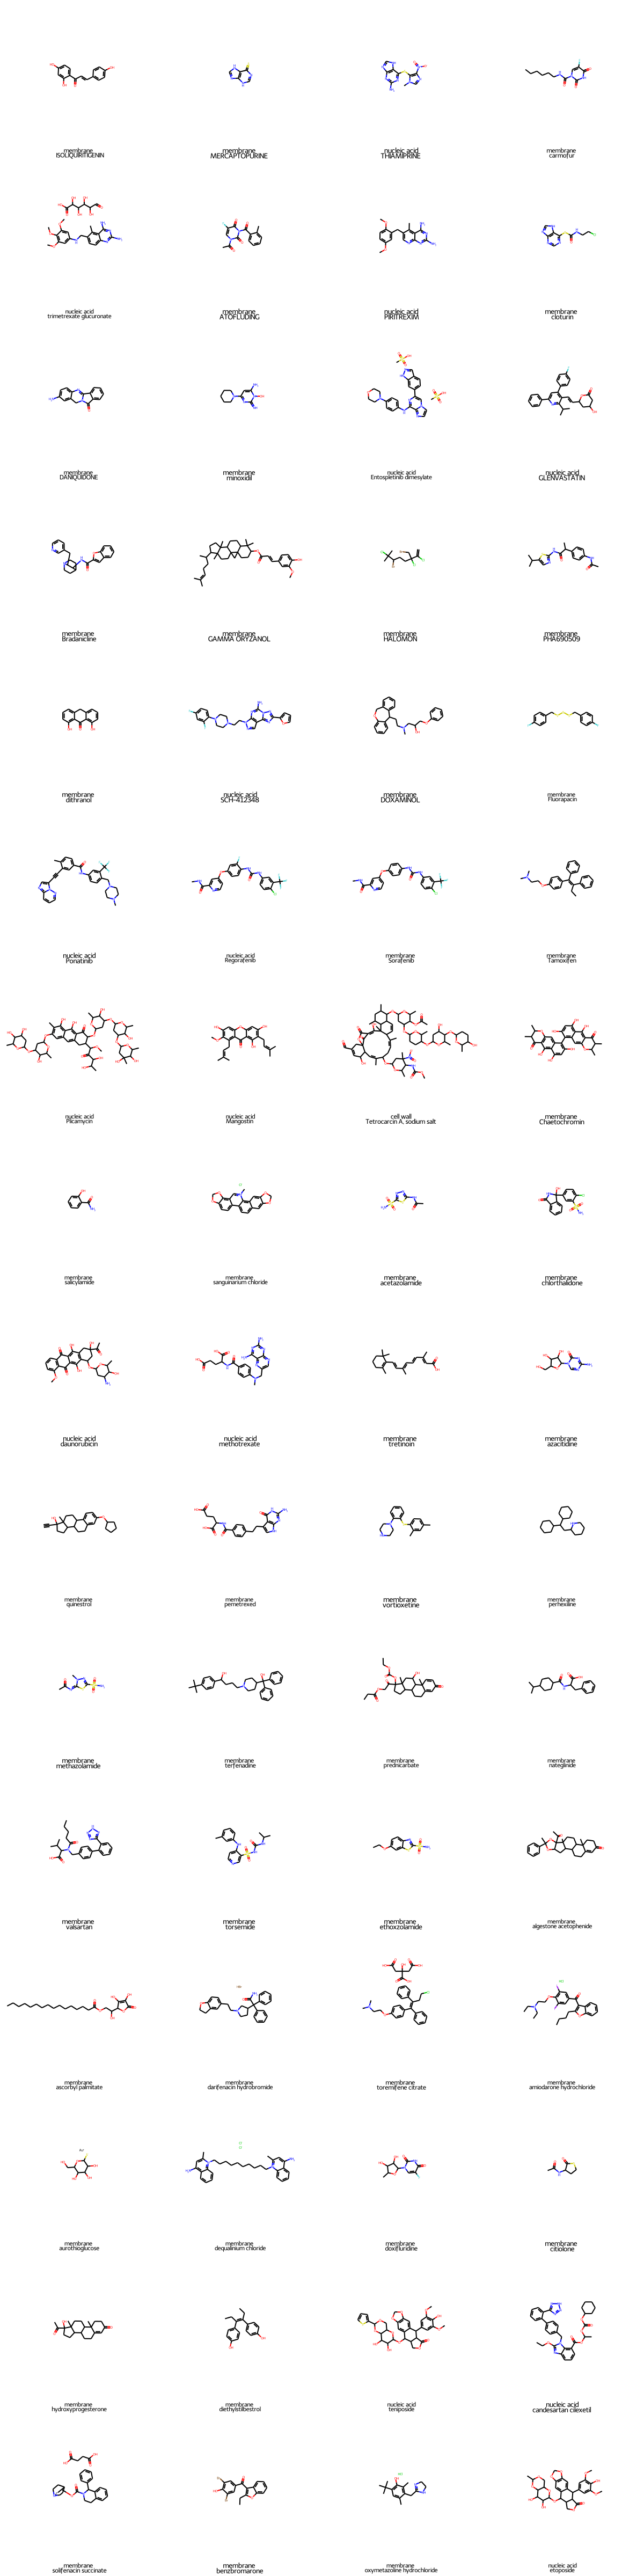

svm ******************************************************************************************************************


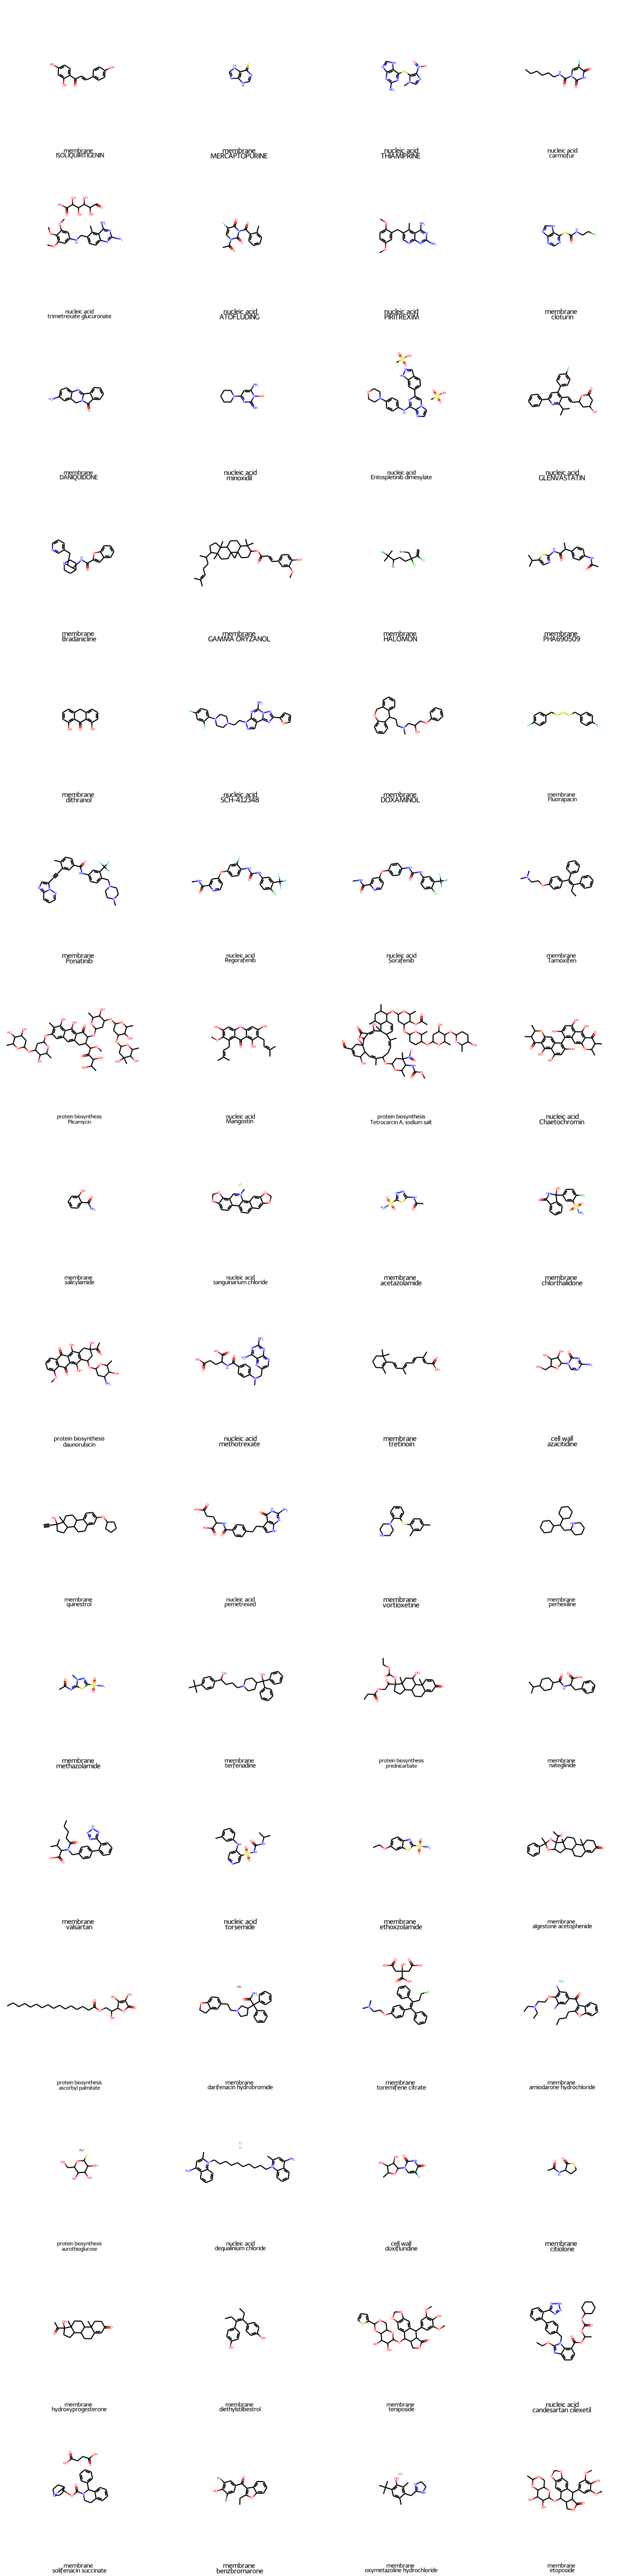

gpc ******************************************************************************************************************


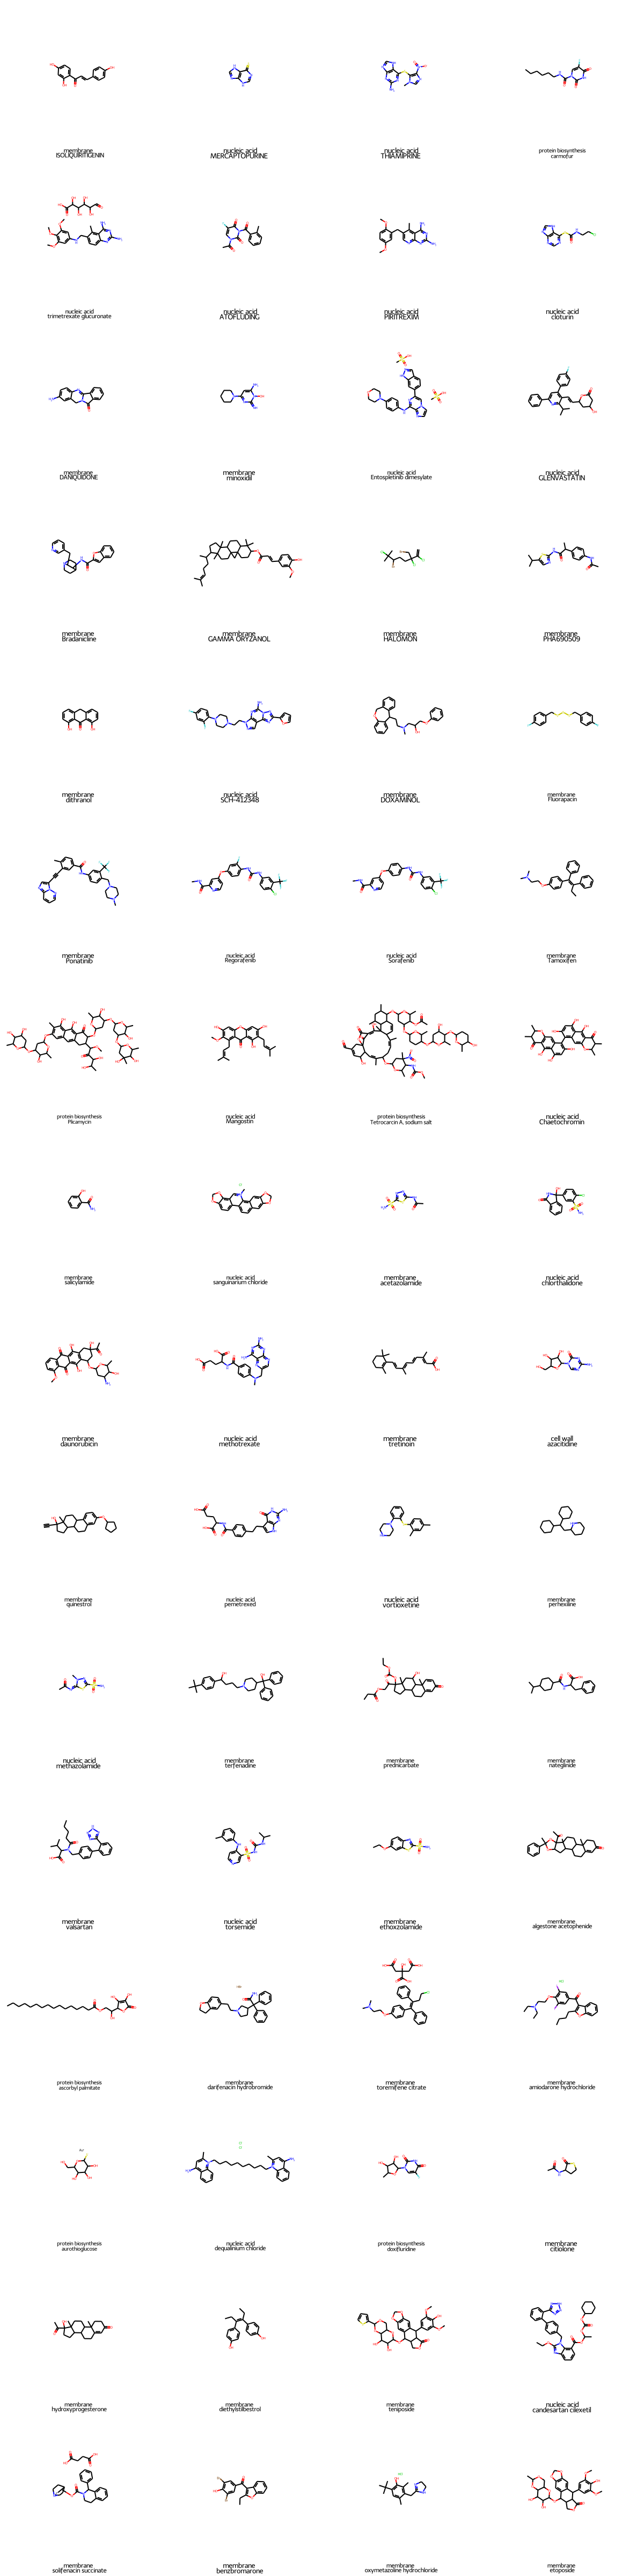

knn ******************************************************************************************************************


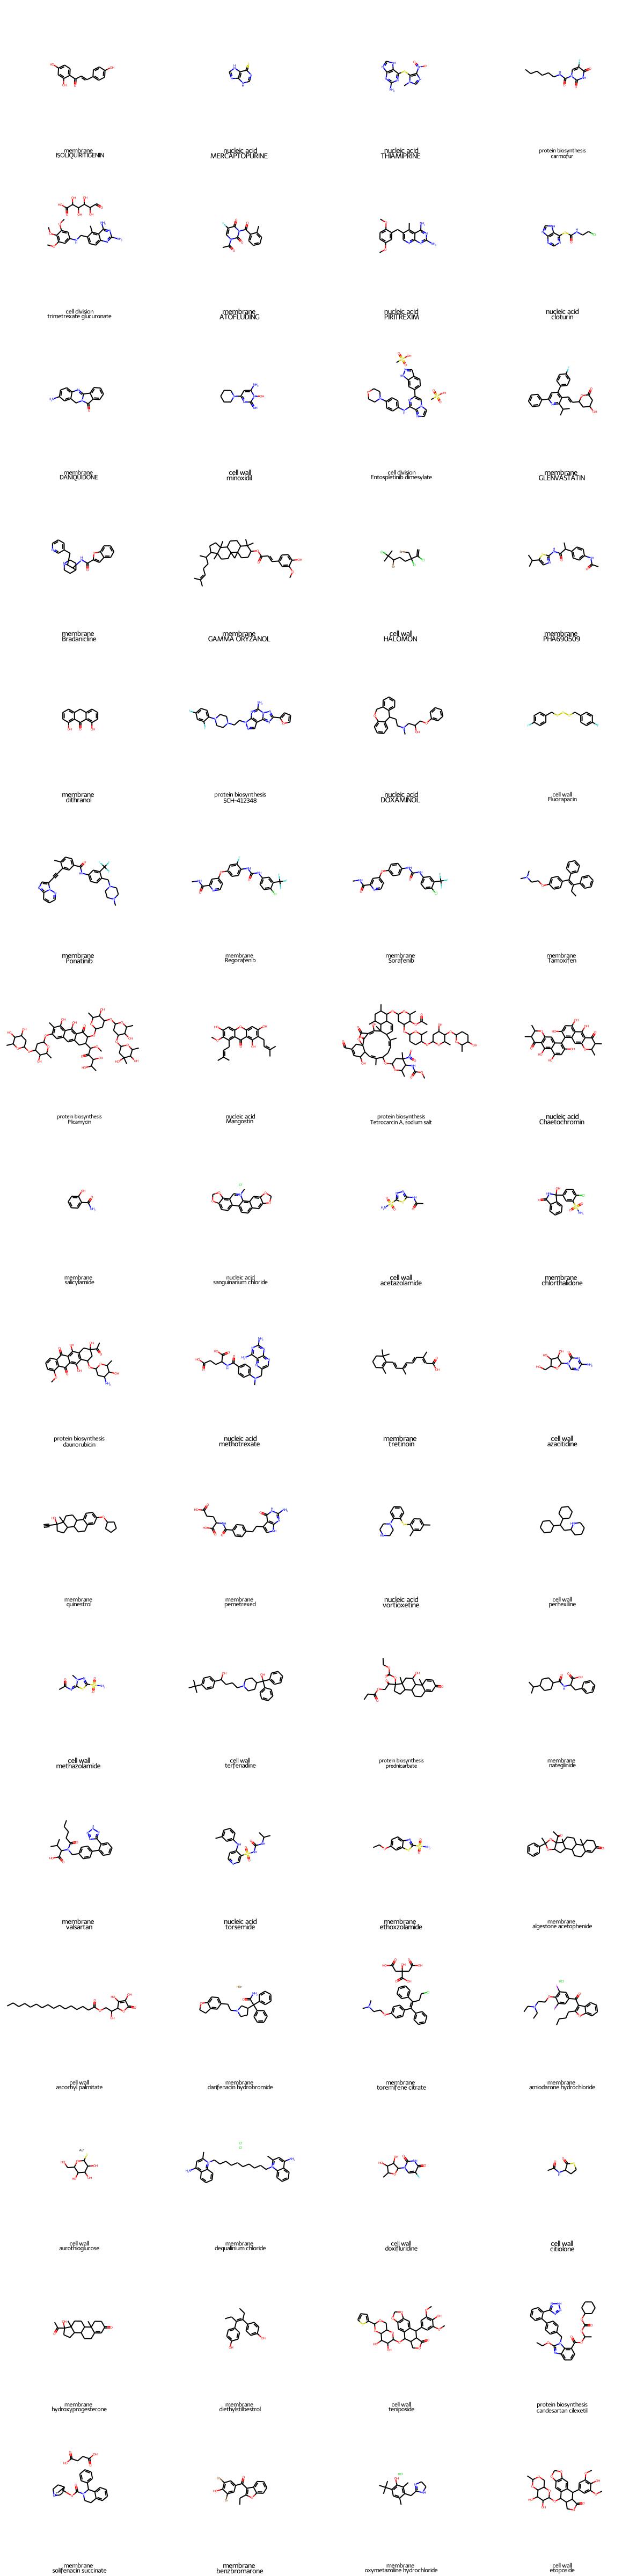

In [32]:
# shows molecular structures of human drugs and the predicted label from each classifier
n_mols = 64

clfs = ['rfc','svm','gpc','knn']
for preds, clf in zip(all_preds, clfs):
    print(clf,'******************************************************************************************************************')
    label_name = [''.join(list(pred+'\n'+name)) for pred, name in zip(preds,names)]
    abx_img = Draw.MolsToGridImage(test_mols, molsPerRow=4, subImgSize=(300,300), returnPNG=False, maxMols=n_mols, legends=label_name)
    abx_img.show()

# Part 4: Models on just RDKit props and RDkit+Morgan fps

In [ ]:
# try classifiers on rdkit props
numsplits = 1
type_of_input = 'rdkit'
model = 'rfc'
filler = '**************************'
print(filler)
print('trying ' + model + ' on rdkit props with ' + str(numsplits) + ' non-overlapping splits')
rfc, rfc_test_acc, rfc_AUROC, rfc_AUPR, rfc_mcc, rfc_cks = classifier(model, numsplits, justprops, props_y, type_of_input=type_of_input)
dump(rfc, '../outputs/rfc_predict_human_'+type_of_input+'.joblib')


numsplits = 1
model = 'svm'
print(filler)
print('trying ' + model + ' on rdkit props with ' + str(numsplits) + ' non-overlapping splits')
svm, svm_test_acc, svm_AUROC, svm_AUPR, svm_mcc, svm_cks = classifier(model, numsplits, justprops, props_y, type_of_input=type_of_input)
dump(svm, '../outputs/svm_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'gpc'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
gpc, gpc_test_acc, gpc_AUROC, gpc_AUPR, gpc_mcc, gpc_cks = classifier(model, numsplits, justprops, props_y, type_of_input=type_of_input)
dump(gpc, '../outputs/gpc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'knn'
print(filler)
print('trying ' + model + ' on morgan fps with ' + str(numsplits) + ' non-overlapping splits')
knn, knn_test_acc, knn_AUROC, knn_AUPR, knn_mcc, knn_cks = classifier(model, numsplits, justprops, props_y, type_of_input=type_of_input)
dump(knn, '../outputs/'+model+'_predict_human_'+type_of_input+'.joblib')


**************************
trying rfc on rdkit+morgan with 1 non-overlapping splits
Accuracy for model 0: 0.8693069306930693


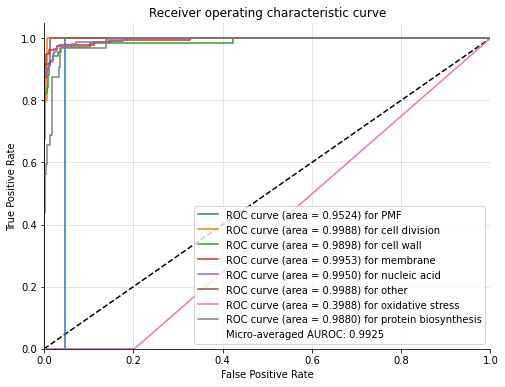

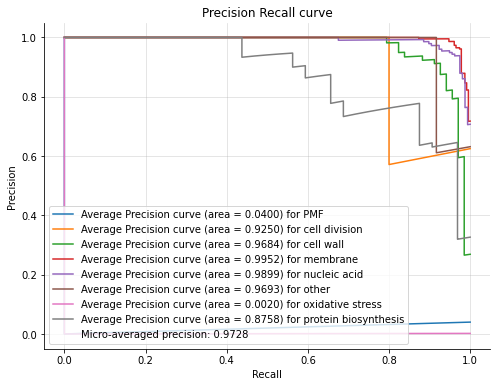

Cohen kappa score: 0.8103200031869426
Matthews correlation coefficient: 0.8196185631994202
**************************
trying svm on rdkit+morgan with 1 non-overlapping splits
Accuracy for model 1: 0.9485148514851485


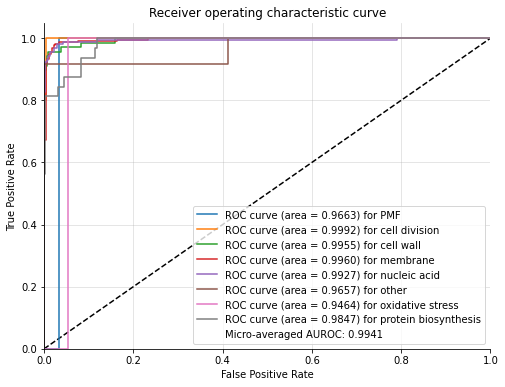

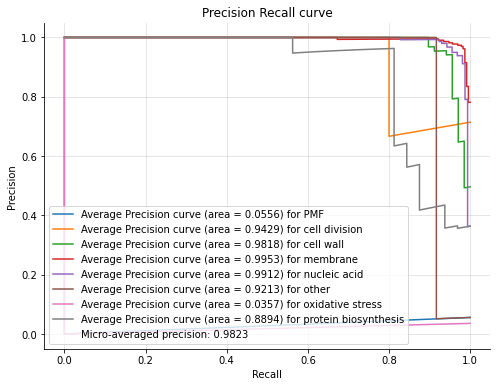

Cohen kappa score: 0.9224842813708416
Matthews correlation coefficient: 0.9231915870001911
**************************
trying knn on rdkit+morgan with 1 non-overlapping splits
Accuracy for model 0: 0.9346534653465347


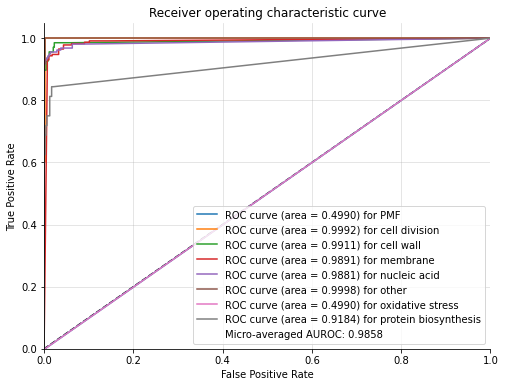

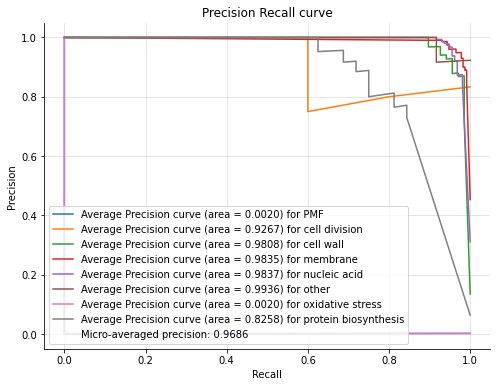

Cohen kappa score: 0.9027644875953975
Matthews correlation coefficient: 0.9029154928021786
**************************
trying gpc on rdkit+morgan with 1 non-overlapping splits


/home/gcai/anaconda3/envs/abx_moa/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [ ]:
# try classifiers on rdkit props+morgan

type_of_input = 'rdkit_morgan'

combos = []
for x, y in zip(justprops, fps):
    x = list(x)
    x.extend(y)
    combos.append(x)

filler = '**************************'

numsplits = 1
model = 'rfc'
print(filler)
print('trying ' + model + ' on rdkit+morgan with ' + str(numsplits) + ' non-overlapping splits')
rfc, rfc_test_acc, rfc_AUROC, rfc_AUPR, rfc_mcc, rfc_cks = classifier(model, numsplits, combos, combos_y, type_of_input=type_of_input)
dump(rfc, '../outputs/rfc_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'svm'
print(filler)
print('trying ' + model + ' on rdkit+morgan with ' + str(numsplits) + ' non-overlapping splits')
svm, svm_test_acc, svm_AUROC, svm_AUPR, svm_mcc, svm_cks = classifier(model, numsplits, combos, combos_y, type_of_input=type_of_input)
dump(svm, '../outputs/svm_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'knn'
print(filler)
print('trying ' + model + ' on rdkit+morgan with ' + str(numsplits) + ' non-overlapping splits')
knn, knn_test_acc, knn_AUROC, knn_AUPR, knn_mcc, knn_cks = classifier(model, numsplits, combos, combos_y, type_of_input=type_of_input)
dump(knn, '../outputs/'+model+'_predict_human_'+type_of_input+'.joblib')

numsplits = 1
model = 'gpc'
print(filler)
print('trying ' + model + ' on rdkit+morgan with ' + str(numsplits) + ' non-overlapping splits')
gpc, gpc_test_acc, gpc_AUROC, gpc_AUPR, gpc_mcc, gpc_cks = classifier(model, numsplits, combos, combos_y, type_of_input=type_of_input)
dump(gpc, '../outputs/gpc_predict_human_'+type_of_input+'.joblib')

# Part 5: Making figures for PRISE presentation

In [51]:
# loading models
gpc = load('../outputs/gpc_morgan_predict_human.joblib')
rfc = load('../outputs/rfc_morgan_predict_human.joblib')
svm = load('../outputs/svm_morgan_predict_human.joblib')
knn = load('../outputs/knn_morgan_predict_human.joblib')

In [59]:
Xtrains, ytrains, Xtests, ytests = class_balanced_split(fps, fps_y, numsplits=1)
X_test = Xtests[0]
y_test = np.vstack(ytests[0])
n_classes = 8
type_of_input='morgan'
auroc_list = []
aupr_list = []
clf_list = [gpc, rfc, svm, knn]
clf_names = ['GPC','RFC','SVM','KNN']

In [60]:
# tanimoto of train and test sets
tanis = []
for fp1 in Xtrains[0]:
    for fp2 in Xtests[0]:
        tanis.append(DataStructs.TanimotoSimilarity(fp1,fp2))
tanis = np.array(tanis)


In [61]:
# similarity between training and test sets
print(np.percentile(tanis,50))
print(np.mean(tanis))
print(np.max(tanis))
print(np.min(tanis))

0.2961595273264402
0.31472565895120846
1.0
0.01607717041800643


In [62]:
for clf, type_of_class in zip(clf_list,clf_names):
    # roc / pr curves
    # plot_roc_prc_curves(clf, type_of_class, X_test, np.vstack(y_test), n_classes, type_of_input, figsize=(8, 6))
    fpr = {}
    tpr = {}
    prc_auc = {}
    roc_auc = {}
    precision = {}
    recall = {}
    if type_of_class == 'RFC' or type_of_class == 'GPC' or type_of_class == 'KNN':
        y_score = clf.predict_proba(X_test) # this makes gpc work even though it's predicting numeric class
    elif type_of_class == 'SVM':
        y_score = clf.decision_function(X_test)
    # auroc / aupr plots
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        prc_auc[i] = average_precision_score(y_test[:, i], y_score[:, i])
    roc_auc[n_classes+1] = roc_auc_score(y_test, y_score, multi_class='ovr', average='micro')
    prc_auc[n_classes+1] = average_precision_score(y_test, y_score, average="micro")
    auroc_list.append(roc_auc)
    aupr_list.append(prc_auc)

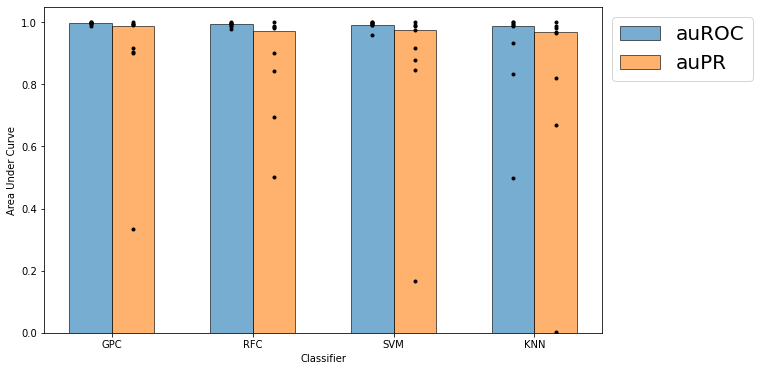

In [63]:
class_list = ['nucleic acid','cell division','cell wall','CoA synthesis','protein biosynthesis','membrane','oxidative stress', 'PMF']
auroc_aupr_dot_barchart('Area Under Curve', auroc_list, aupr_list, class_list, clf_names, clf_list, width=0.3)

In [64]:
# bar chart of test acc, MCC, CKS
accs = {}
ckss = {}
mccs = {}
i = 0
for clf, type_of_class in zip(clf_list,clf_names):
    ypreds = []
    ytrue = []
    if type_of_class == 'RFC':
        ypred = clf.predict(Xtests[i])
        ypred_numeric = np.array([np.argmax(pred) for pred in ypred])
        ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
        ypreds.extend(ypred_numeric)
        ytrue.extend(ytest_numeric)
        acc = clf.score(X_test, y_test)
        
    elif type_of_class == 'SVM':
        ypred = clf.predict(Xtests[i])
        ypred_numeric = ypred
        ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
        ypreds.extend(ypred_numeric)
        ytrue.extend(ytest_numeric)
        acc = clf.score(X_test, ytest_numeric)
        
    elif type_of_class == 'GPC':
        ypred = clf.predict(Xtests[i])
        ypred_numeric = ypred
        ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
        ypreds.extend(ypred_numeric)
        ytrue.extend(ytest_numeric)
        acc = clf.score(X_test, ytest_numeric)
        
    elif type_of_class == 'KNN':
        ypred = clf.predict(Xtests[i])
        ypred_numeric = ypred #np.array([np.argmax(pred) for pred in ypred])
        ytest_numeric = np.array([np.argmax(ytest) for ytest in ytests[i]])
        ypreds.extend(ypred_numeric)
        ytrue.extend(ytest_numeric)
        acc = clf.score(X_test, ytest_numeric)
    accs[type_of_class] = acc
    mccs[type_of_class] = matthews_corrcoef(ypreds, ytrue)
    ckss[type_of_class] = cohen_kappa_score(ypreds, ytrue)        

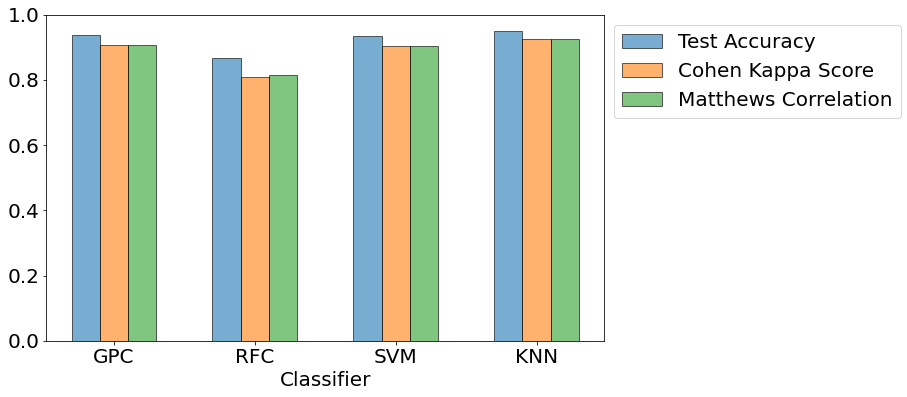

In [66]:
multiclass_metrics_barchart('', accs, ckss, mccs, clf_names, clf_list, width=0.2)

<ipython-input-65-e967584bbc30>:104: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
<ipython-input-65-e967584bbc30>:132: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


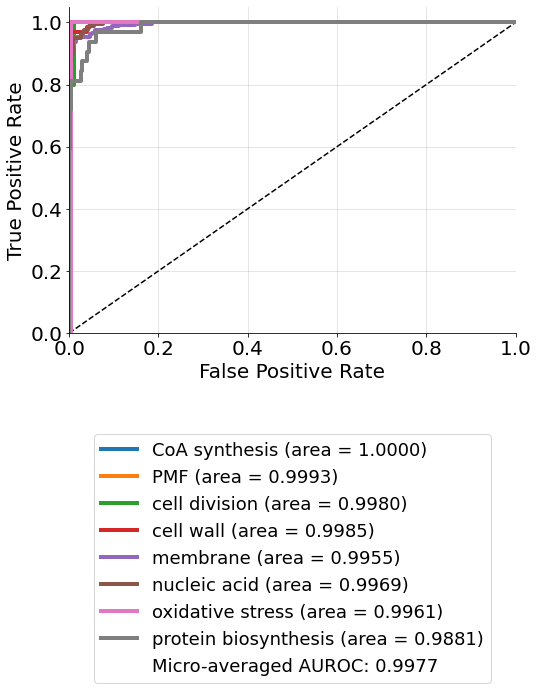

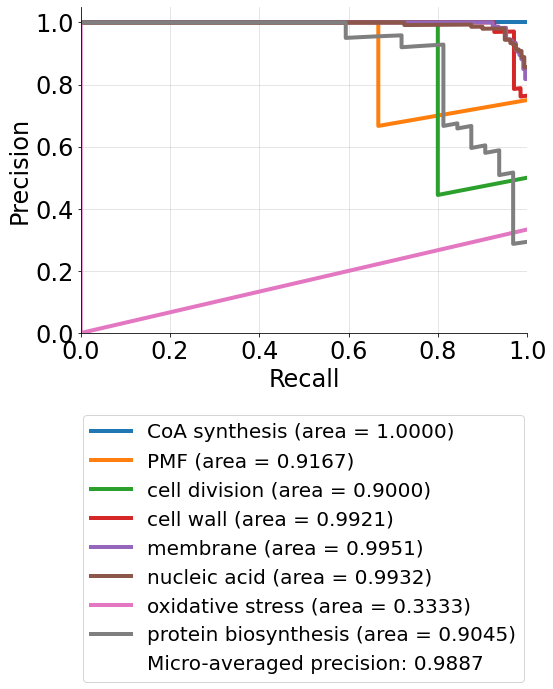

[{0: 1.0,
  1: 0.9993476842791911,
  2: 0.9980353634577603,
  3: 0.9985162226325508,
  4: 0.9955128205128204,
  5: 0.9969103107344632,
  6: 0.9961013645224172,
  7: 0.9881353734439834,
  9: 0.9976975968058346},
 {0: 1.0,
  1: 0.9166666666666665,
  2: 0.8999999999999999,
  3: 0.9920987455391221,
  4: 0.9950982166308487,
  5: 0.9932290013167756,
  6: 0.3333333333333333,
  7: 0.9044896572729211,
  9: 0.9886676740771948}]

In [67]:
plot_roc_prc_curves(gpc, 'gpc', X_test, y_test, n_classes, type_of_input, figsize=(8, 6))